In [ ]:

import torch.utils.data as data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from scikeras.wrappers import KerasRegressor 
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import access_merge as access_merge
import seaborn as sns
import sys, os
sys.path.append(os.path.abspath(".."))

import utils.lstm as lstm
from utils.logger import Logger
logger = Logger.configurar_logger(nome_arquivo="biLstmMERGE.log", nome_classe="BiLstm MERGE")
logger.info("Iniciando script de previsão com BiLSTM Merge(TensorFlow/Keras).")
param_grid = {
    'model__units_camada1': [32, 64],
    'model__units_camada2': [16, 32],
    'model__dropout_rate': [0.2, 0.3],
    'model__activation': ['relu', 'tanh'],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64],
    'epochs': [50] 
}

2025-10-10 10:44:36.571705: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-10 10:44:38,955 - BiLstm MERGE - INFO - Iniciando script de previsão com BiLSTM Merge(TensorFlow/Keras).


Lido 1998-01-02
Lido 1998-01-03
Lido 1998-01-04
Lido 1998-01-05
Lido 1998-01-06
Lido 1998-01-07
Lido 1998-01-08
Lido 1998-01-09
Lido 1998-01-10
Lido 1998-01-11
Lido 1998-01-12
Lido 1998-01-13
Lido 1998-01-14
Lido 1998-01-15
Lido 1998-01-16
Lido 1998-01-17
Lido 1998-01-18
Lido 1998-01-19
Lido 1998-01-20
Lido 1998-01-21
Lido 1998-01-22
Lido 1998-01-23
Lido 1998-01-24
Lido 1998-01-25
Lido 1998-01-26
Lido 1998-01-27
Lido 1998-01-28
Lido 1998-01-29
Lido 1998-01-30
Lido 1998-01-31
Lido 1998-02-01
Lido 1998-02-02
Lido 1998-02-03
Lido 1998-02-04
Lido 1998-02-05
Lido 1998-02-06
Lido 1998-02-07
Lido 1998-02-08
Lido 1998-02-09
Lido 1998-02-10
Lido 1998-02-11
Lido 1998-02-12
Lido 1998-02-13
Lido 1998-02-14
Lido 1998-02-15
Lido 1998-02-16
Lido 1998-02-17
Lido 1998-02-18
Lido 1998-02-19
Lido 1998-02-20
Lido 1998-02-21
Lido 1998-02-22
Lido 1998-02-23
Lido 1998-02-24
Lido 1998-02-25
Lido 1998-02-26
Lido 1998-02-27
Lido 1998-02-28
Lido 1998-03-01
Lido 1998-03-02
Lido 1998-03-03
Lido 1998-03-04
Lido 199

2025-10-10 10:45:46,374 - BiLstm MERGE - INFO - Dados carregados com sucesso. Total de 2000 registros.


Lido 2003-06-23
Lido 2003-06-24
Lido 2003-06-25


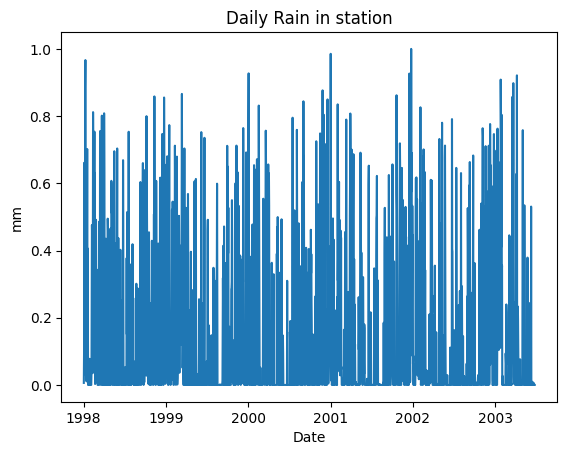

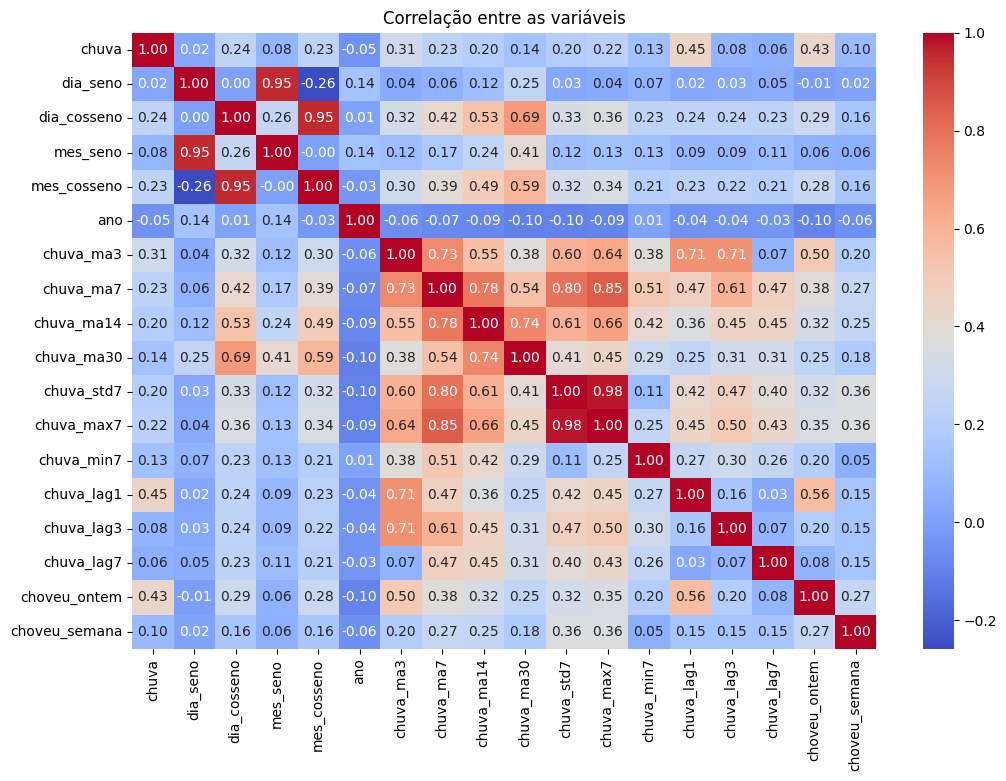

In [3]:
timeseries = access_merge.acessar_dados_merge()
timeseries['chuva'] = np.log1p(timeseries['chuva'])

num_features = 18
# 2. FEATURES TEMPORAIS
timeseries['dia_seno'] = np.sin(2 * np.pi * timeseries.index.dayofyear / 365)
timeseries['dia_cosseno'] = np.cos(2 * np.pi * timeseries.index.dayofyear / 365)
timeseries['mes_seno'] = np.sin(2 * np.pi * timeseries.index.month / 12)
timeseries['mes_cosseno'] = np.cos(2 * np.pi * timeseries.index.month / 12)
timeseries['ano'] = timeseries.index.year - timeseries.index.year.min()


timeseries['chuva_ma3']  = timeseries['chuva'].shift(1).rolling(window=3, min_periods=1).mean().fillna(0)
timeseries['chuva_ma7']  = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).mean().fillna(0)
timeseries['chuva_ma14'] = timeseries['chuva'].shift(1).rolling(window=14, min_periods=1).mean().fillna(0)
timeseries['chuva_ma30'] = timeseries['chuva'].shift(1).rolling(window=30, min_periods=1).mean().fillna(0)

# 2. Estatísticas móveis
timeseries['chuva_std7'] = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).std().fillna(0)
timeseries['chuva_max7'] = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).max().fillna(0)
timeseries['chuva_min7'] = timeseries['chuva'].shift(1).rolling(window=7, min_periods=1).min().fillna(0)

# 3. Lags
timeseries['chuva_lag1'] = timeseries['chuva'].shift(1).fillna(0)
timeseries['chuva_lag3'] = timeseries['chuva'].shift(3).fillna(0)
timeseries['chuva_lag7'] = timeseries['chuva'].shift(7).fillna(0)

# 5. Flags binários
timeseries['choveu_ontem'] = (timeseries['chuva_lag1'] > 0).astype(int)
timeseries['choveu_semana'] = (timeseries['chuva_ma7'] > 0).astype(int)

features_dinamicas = [col for col in timeseries.columns if 'chuva' in col]
features_sazonais = ['dia_seno', 'dia_cosseno', 'mes_seno', 'mes_cosseno', 'ano']
scaler_chuva = MinMaxScaler()
timeseries[features_dinamicas] = scaler_chuva.fit_transform(timeseries[features_dinamicas])

logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
datas = timeseries.index 

plt.plot(timeseries['chuva'])
plt.title('Daily Rain in station')
plt.xlabel('Date')
plt.ylabel('mm')
plt.show()

plt.figure(figsize=(12,8))
corr = timeseries.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlação entre as variáveis")
plt.show()

In [4]:
lookback = 14
logger.info(f"Preparando sequências com um lookback de {lookback} dias.")
X, y = lstm.create_sequence(timeseries.values, lookback)
dates_aligned = datas[lookback:]

train_size = int(len(X) * 0.70)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")
logger.info(f"Shape {X_train.shape}")



2025-10-10 10:46:10,969 - BiLstm MERGE - INFO - Preparando sequências com um lookback de 14 dias.
2025-10-10 10:46:10,975 - BiLstm MERGE - INFO - Sequências criadas. Treino: 1390 amostras, Teste: 596 amostras.
2025-10-10 10:46:10,977 - BiLstm MERGE - INFO - Shape (1390, 14, 18)


In [ ]:
model_wrapper = KerasRegressor(model=lstm.criar_modelo_avancado, verbose=0)
n_splits = 3 # Número de divisões para a validação cruzada
tscv = TimeSeriesSplit(n_splits=n_splits)

# Cria a instância do GridSearchCV
grid = GridSearchCV(
    estimator=model_wrapper,
    param_grid=param_grid,
    cv=tscv,          # Validação cruzada para séries temporais
    n_jobs=-1,        # Usar todos os processadores disponíveis
    verbose=2         # Mostra o progresso
)

# Inicia a busca (isso pode demorar MUITO)
grid_result = grid.fit(X_train, y_train) 

logger.info("GridSearchCV finalizado.")
logger.info(f"Melhores parâmetros encontrados: {grid_result.best_params_}")
logger.info(f"Melhor score de validação cruzada (negativo da MSE): {grid_result.best_score_:.4f}")

# Você pode pegar o melhor modelo treinado para fazer previsões
best_model = grid_result.best_estimator_

Fitting 3 folds for each of 64 candidates, totalling 192 fits


2025-10-10 10:46:28.745556: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-10 10:46:28.745571: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-10 10:46:28.745582: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-10 10:46:28.745625: I tensorflow/core/platform/cpu_featu

In [ ]:
epochs = 1000
batch_size = 32
# Building the model

model = lstm.criar_modelo_avancado(
    lookback=lookback,
    n_features=num_features,
    units_camada1=128,
    units_camada2=64,
    dropout_rate=0.2
)
logger.info(f"Iniciando treinamento por {epochs} épocas. Com batch_size: {batch_size}")


print(model.summary())
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
# patience=15: espera 30 épocas sem melhora antes de parar

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=25, min_lr=1e-6, verbose=1)
# factor=0.2: reduz o learning rate para 20% do valor atual
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size
    #callbacks=[ early_stopping, reduce_lr ]
)
logger.info("Treinamento concluído.")


2025-10-09 22:52:25,049 - BiLstm MERGE - INFO - Iniciando treinamento por 1000 épocas. Com batch_size: 32


Model: "BiLSTM_Melhorado"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ (None, 14, 600)        │       765,600 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 14, 600)        │     2,162,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 64)             │       162,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,096,321 (11.81 MB)

 Trainable params: 3,096,321 (11.81 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - loss: 0.0724 - mae: 0.2075 - val_loss: 71.8475 - val_mae: 3.0458
Epoch 2/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0487 - mae: 0.1763 - val_loss: 71.8596 - val_mae: 3.0433
Epoch 3/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0469 - mae: 0.1725 - val_loss: 71.5178 - val_mae: 3.0440
Epoch 4/1000
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0460 - mae: 0.1697 - val_loss: 72.1481 - val_mae: 3.0329
Epoch 5/1000
22/44 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0446 - mae: 0.1557

KeyboardInterrupt: 

In [ ]:
# --- Previsão ---
logger.info("Realizando previsões no conjunto de teste.")
pred = model.predict(X_test)

n_features_chuva = scaler_chuva.n_features_in_
pred_dummy = np.zeros((len(pred), n_features_chuva))
pred_dummy[:, 0] = pred.flatten()
pred_log = scaler_chuva.inverse_transform(pred_dummy)[:, 0]
pred = np.expm1(pred_log)

y_test_dummy = np.zeros((len(y_test), n_features_chuva))
y_test_dummy[:, 0] = y_test.flatten()
y_testlog = scaler_chuva.inverse_transform(y_test_dummy )[:, 0]
y_test = np.expm1(y_testlog)

rmse = np.sqrt(mean_squared_error(y_test, pred))
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
logger.info("--- Métricas de Avaliação no Conjunto de Teste ---")
logger.info(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")
logger.info(f"MSE (Erro Quadrático Médio): {mse:.4f}")
logger.info(f"MAE (Erro Absoluto Médio): {mae:.4f}")
logger.info("-------------------------------------------------")

2025-10-09 22:41:09,387 - BiLstm MERGE - INFO - Realizando previsões no conjunto de teste.


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


2025-10-09 22:41:10,875 - BiLstm MERGE - INFO - Avaliação do Modelo - RMSE: 8.2798, MSE: 68.5543, MAE: 3.3739


2025-10-09 22:41:13,477 - BiLstm MERGE - INFO - Gerando gráfico de previsão final.


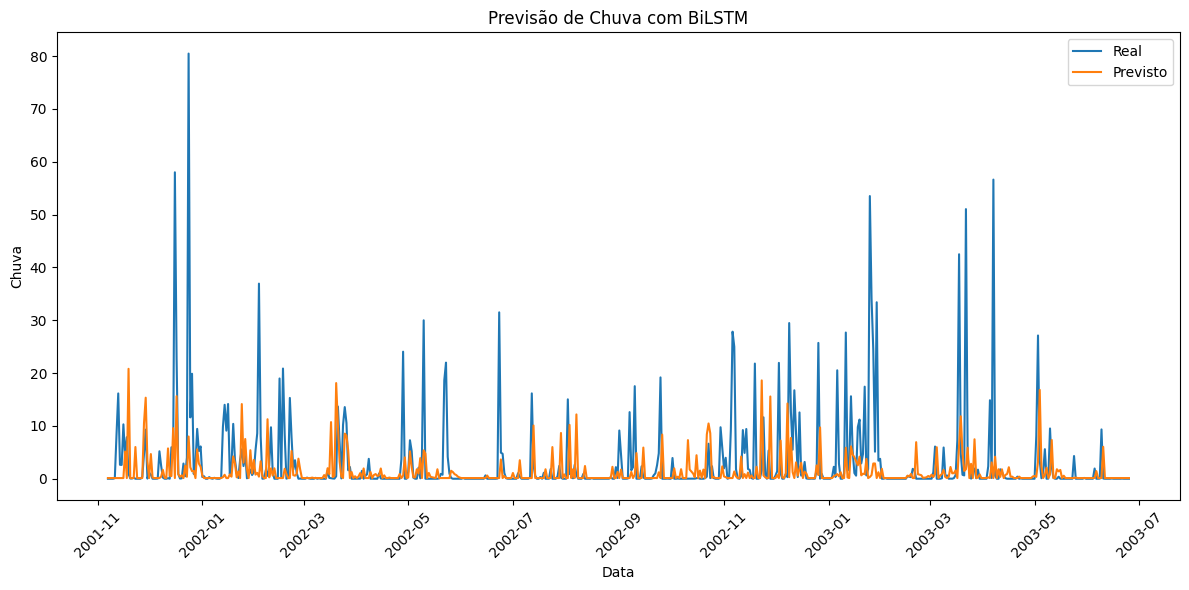

2025-10-09 22:41:13,633 - BiLstm MERGE - INFO - Script BiLSTM BrDwgd(TensorFlow/Keras) finalizado.


In [13]:
logger.info("Gerando gráfico de previsão final.")
plt.figure(figsize=(12,6))
plt.plot(test_date, y_test, label="Real")
plt.plot(test_date, pred, label="Previsto")
plt.legend()
plt.title("Previsão de Chuva com BiLSTM")
plt.xlabel("Data")
plt.ylabel("Chuva")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
logger.info("Script BiLSTM BrDwgd(TensorFlow/Keras) finalizado.")